In [86]:
# def unprocess_image(image_path: Path, original_image_path: Path, reshape_size: int = 180):

#     """Reverse torchio preprocessing 

#     Args:
#         image_path (Path): Path to the image to be unprocessed (usually a XAI map)
#         original_image_path (Path): Path to the original image (usually brain_masked volume)
#         reshape_size (int, optional): Reshape size for the CropOrPad tio transform. Defaults to 180.

#     Returns:
#         img_to_original (nib): Nibabel image with the same orientation and dimensions as the original image
#     """
#     og_subject = tio.Subject(image=tio.ScalarImage(original_image_path))
#     preprocess = tio.Compose(
#             [   tio.ToCanonical(),
#                 tio.CropOrPad(reshape_size, 
#                               padding_mode='minimum')
#             ])
#     og_subject_proc = preprocess(og_subject)    

#     inv_crop = og_subject_proc.get_inverse_transform()
#     image_nib = nib.load(image_path)
#     if image_nib.shape != og_subject_proc.image.shape[1:]:
#         print(f'Image shape {image_nib.shape} does not match preprocessed original image shape {og_subject_proc.image.shape[1:]}')
#         return None

#     img_ornt = nib.orientations.io_orientation(image_nib.affine)
#     psr_ornt = nib.orientations.io_orientation(og_subject_proc.image.affine)
#     # Uncrop
#     image_nib = inv_crop(image_nib)
#     # FromCanonical
#     from_canonical = nib.orientations.ornt_transform(img_ornt, psr_ornt)
#     img_to_original = image_nib.as_reoriented(from_canonical)
    
#     if (img_to_original.affine == og_subject.image.affine).all:
#         return img_to_original
#     else:
#         print('Failed: Affine mismatch')
#         return None

In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import nibabel as nib
import SimpleITK as sitk
import yaml
import torchio as tio
from dataset.hmri_dataset import HMRIDataModule,HMRIDataModuleDownstream
from monai.transforms import Compose

from models.pl_model import Model, ModelDownstream, ContrastiveLearning
import torch
from utils.utils import get_pretrained_model, save_nifti_from_array, unprocess_image
this_path = Path().resolve()
from monai.transforms import (
    LoadImage,
    ResizeWithPadOrCrop,
    RandCoarseShuffle,
    RandCoarseDropout,
    RandSpatialCropSamples,
    Resize,
    RandFlip,
    RandAffine,
    OneOf,
    EnsureChannelFirst, Compose, RandRotate90, Resize, ScaleIntensity
)
from monai.data import ImageDataset, DataLoader
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split


# import torch
# import torchvision

this_path = Path().resolve()
# study_path = Path("/mrhome/kristiannm/tmp")
# "X95478_T2w.nii"

In [2]:
def get_indexes_from_cfg(chkpt_path):

    exp_dir = chkpt_path.parent.parent.parent
    with open(exp_dir /'config_dump.yml', 'r') as f:
        cv_cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]
    
    train_index = cv_cfg['train_idxs'].replace('[', '').replace(']', '').replace('\n', '').split(' ')
    train_index = [int(i) for i in train_index if i != '']

    test_index = cv_cfg['test_idxs'].replace('[', '').replace(']', '').replace('\n', '').split(' ')
    test_index = [int(i) for i in test_index if i != '']

    return train_index, test_index

In [3]:
# load config file    
ckpt_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/new_p1_hmri_outs/cv2-4A_hMRI_R2s_WLS1_optim_adam_lr_0.01_cv_3/version_0/checkpoints/epoch=65-val_auroc=0.7551.ckpt')
exp_dir = ckpt_path.parent.parent.parent
with open(exp_dir /'config_dump.yml', 'r') as f:
    exp_cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

exp_cfg['dataset']['val_batch_size'] = 1
root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
pd_number = len(md_df.loc[md_df.group == 1, :])
hc_number = len(md_df.loc[md_df.group == 0, :])
print(f'------------\n Data - PD: {pd_number}, HC: {hc_number}')

data = HMRIDataModule(root_dir=root_dir,
                            md_df=md_df,
                            augment=None,
                            **exp_cfg['dataset'])
train_idxs, val_indxs = get_indexes_from_cfg(ckpt_path)
data.prepare_data(train_idxs=train_idxs, val_idxs=val_indxs)
data.setup()

------------
 Data - PD: 49, HC: 23
Drop subjects ['sub-058', 'sub-016']


In [4]:
exp_name = '4A_hMRI_R2s_WLS1_optim_adam_lr_0.01'
val_subjects = data.md_df_val.id.values.tolist()
print(val_subjects)
xai_map_types = ['occ_sens', 'grad_based']

for subj_id in val_subjects:
    print(f'Processing {subj_id}')
    for xai_map_type in xai_map_types:
        if xai_map_type == 'occ_sens':  
            xai_path = Path(f'/mrhome/alejandrocu/Documents/parkinson_classification/xai_outs/{subj_id}/occ_sens/{exp_name}/final_{subj_id}_R2s_WLS1_occ_s5_ps8_og_img.nii.gz')
        elif xai_map_type == 'grad_based':
            xai_path = Path(f'/mrhome/alejandrocu/Documents/parkinson_classification/xai_outs/{subj_id}/grad_based/{exp_name}/final_{subj_id}_R2s_WLS1_IntegratedGrads_nsteps_200_result.nii.gz')

        original_image_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subj_id}/Results/brain_masked/{subj_id}_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_R2s_WLS1_w.nii')
        img_to_original = unprocess_image(xai_path, original_image_path)
        if img_to_original is not None:
            out_path = original_image_path.parent.parent / 'xai'
            out_path.mkdir(exist_ok=True, parents=True)
            nib.save(img_to_original, out_path / f'odim_{xai_path.name}')

Processing sub-021


/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/torchio/transforms/augmentation/composition.py:69: RuntimeWarning: Skipping ToCanonical as it is not invertible
  warnings.warn(message, RuntimeWarning)


Processing sub-064
Processing sub-042
Processing sub-066
Processing sub-041
Processing sub-019
Processing sub-036
Processing sub-039
Processing sub-035
Processing sub-071
Processing sub-030
Processing sub-015
Processing sub-032
Processing sub-050


In [14]:
# create atlas tio image and preprocess
subj_id = 'sub-021'
atlas_path = root_dir / subj_id / 'Results/antsreg_greedy' / f'T1_R1_SyNRA_CC_pd25T1toR1_warped_atlas.nii'
xai_path = Path(f'/mrhome/alejandrocu/Documents/parkinson_classification/xai_outs/{subj_id}/occ_sens/4A_hMRI_R2s_WLS1_optim_adam_lr_0.01')
xai_image = tio.Subject(image=tio.ScalarImage(xai_path / f'final_{subj_id}_R2s_WLS1_occ_s5_ps8_og_img.nii.gz'))
subject_image = tio.ScalarImage(atlas_path)
subject = tio.Subject(image=subject_image)
affine_m = subject_image['affine']
print(subject_image[tio.DATA].shape)
preprocess = tio.Compose(
            [   tio.ToCanonical(),
                tio.CropOrPad(data.reshape_size, 
                              padding_mode='minimum')
            ]
        )
subject_image_proc = preprocess(subject)
print(subject_image_proc['image'][tio.DATA].shape)
out_dir = Path(f'/mrhome/alejandrocu/Documents/parkinson_classification/xai_outs/{subj_id}/occ_sens/4A_hMRI_R2s_WLS1_optim_adam_lr_0.01')
# save_nifti_from_array(subj_id=subj_id,
#                     arr=subject_image_proc[tio.DATA][0].detach().cpu().numpy(),
#                     affine_matrix=affine_m, 
#                     path=out_dir / f'final_{subj_id}_cropped_atlas.nii.gz')


torch.Size([1, 192, 167, 154])
torch.Size([1, 180, 180, 180])


In [51]:
inv_crop = subject_image_proc.get_inverse_transform()
xai_nib = nib.load(xai_path / f'final_{subj_id}_R2s_WLS1_occ_s5_ps8_og_img.nii.gz')
print(nib.aff2axcodes(xai_nib.affine), xai_nib.shape)
img_ornt = nib.orientations.io_orientation(xai_nib.affine)
psr_ornt = nib.orientations.axcodes2ornt("PSR")
# Uncrop
img_original = inv_crop(xai_nib)
# FromCanonical
from_canonical = nib.orientations.ornt_transform(img_ornt, psr_ornt)
img_original = img_original.as_reoriented(from_canonical)
print(nib.aff2axcodes(img_original.affine), img_original.shape)

('R', 'A', 'S') (180, 180, 180)
('P', 'S', 'R') (192, 167, 154)


/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/torchio/transforms/augmentation/composition.py:69: RuntimeWarning: Skipping ToCanonical as it is not invertible
  warnings.warn(message, RuntimeWarning)


In [7]:
with open('./config/config.yaml', 'r') as f:
        cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]
# Set data directory
root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
pd_number = len(md_df.loc[md_df.group == 1, :])
hc_number = len(md_df.loc[md_df.group == 0, :])
print(f'------------\n Data - PD: {pd_number}, HC: {hc_number}')

data = HMRIDataModuleDownstream(root_dir=root_dir,
                            md_df=md_df,
                            augment=None,
                            **cfg['dataset'])
data.prepare_data()
data.setup()

------------
 Data - PD: 49, HC: 23
Drop subjects ['sub-058', 'sub-016']


In [17]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)

for i, (train_index, test_index) in enumerate(skf.split(md_df.id.values, md_df.group.values)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[11 12 13 14 15 17 19 20 21 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37
 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 62 63 64 65 66 67 68 69]
  Test:  index=[ 0  1  2  3  4  5  6  7  8  9 10 16 18 22]
Fold 1:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 16 18 22 27 29 30 31 32 33 34 35 36 37
 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 62 63 64 65 66 67 68 69]
  Test:  index=[11 12 13 14 15 17 19 20 21 23 24 25 26 28]
Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 41 42 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 62 63 64 65 66 67 68 69]
  Test:  index=[27 29 30 31 32 33 34 35 36 37 38 39 40 43]
Fold 3:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 43 55 57 58 59 60 61
 62 63 64 65 66 67 68 69]
  Test:  index=[41 42 44 45 46 47 48 49 50 

In [56]:
class HMRIDataCLR(pl.LightningDataModule):
    def __init__(self, 
                md_df, 
                root_dir,
                train_batch_size = 4,
                val_batch_size = 4,
                train_num_workers = 4,
                val_num_workers = 4, 
                reshape_size = (128, 128, 128), 
                test_split = 0.2, 
                random_state = 42,
                map_type = ['MTsat'],
                windowed_dataset = False,
                masked = 'brain_masked',
                weighted_sampler = False,
                augment = None,
                shuffle = True):
        super().__init__()
        self.md_df = md_df
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.train_num_workers = train_num_workers
        self.val_num_workers = val_num_workers
        self.root_dir = root_dir
        self.reshape_size = reshape_size
        self.test_split = test_split
        self.random_state = random_state
        self.map_type = map_type
        self.windowed_dataset = windowed_dataset
        self.masked = masked
        self.weighted_sampler = weighted_sampler
        self.augment = augment
        self.shuffle = shuffle
        self.subjects = None
        self.test_subjects = None
        self.preprocess = None
        self.transform = None
        self.train_set = None
        self.val_set = None
        self.test_set = None

    def get_subjects_list(self, md_df):

        subjects_list = []
        # subjects_labels = []
        md_df.reset_index(inplace=True, drop=True)

        for i in range(len(md_df)):

            # select the correct folder of masked volumes
            subj_dir = self.root_dir / md_df['id'][i] / 'Results' / self.masked
            subj_dir.exists()
            # get all windowed nifti volumes
            hmri_files = sorted(list(subj_dir.glob('*_w.nii')), key=lambda x: x.stem)

            # get only maps of interest
            hmri_files = [x for x in hmri_files if any(sub in x.stem for sub in self.map_type)]

            subjects_list.append(str(hmri_files[0]))
            # subjects_labels.append(md_df['group'][i])

        return subjects_list #, subjects_labels

    def prepare_data(self):

        # split ratio train = 0.6, val = 0.2, test = 0.2

        # drop subject 058 because it doesn't have maps
        # 'sub-016' has PD* map completely black
        # sub-025 has no brain mask
        subjs_to_drop = ['sub-058', 'sub-016']
        # if self.brain_masked:
        #     subjs_to_drop.append('sub-025')

        for drop_id in subjs_to_drop:
            self.md_df.drop(self.md_df[self.md_df.id == drop_id].index, inplace=True)
        self.md_df.reset_index(drop=True, inplace=True)
        print(f'Drop subjects {subjs_to_drop}')

        self.md_df_train, self.md_df_val = train_test_split(self.md_df, test_size=self.test_split, 
                                                            random_state=42, stratify=self.md_df.loc[:, 'group'].values)
        # self.md_df_train, self.md_df_val = train_test_split(md_df_train_, test_size=0.25,
        #                                         random_state=self.random_state, stratify=md_df_train_.loc[:, 'group'].values)
                                                
        self.train_subjects = self.get_subjects_list(self.md_df_train)
        self.val_subjects = self.get_subjects_list(self.md_df_val)

        # self.test_subjects = []
        # for image_path, label in zip(image_test_paths, labels_test):
        #     subject = tio.Subject(image=tio.ScalarImage(image_path), label=nn.functional.one_hot(as_tensor(label), num_classes=2).float())
        #     self.test_subjects.append(subject)

    def get_preprocessing_transform(self):

        preprocess = Compose([
                # LoadImage(),
                EnsureChannelFirst(),
                ScaleIntensity(minv=0, maxv=1),
                ResizeWithPadOrCrop(self.reshape_size, mode='minimum')
            ]
        )
        return preprocess

    def get_augmentation_transform(self):

        # If no augmentation is specified, use the default one
        if self.augment == None:
            self.augment = tio.Compose([
                                        tio.RandomAffine(),
                                        tio.RandomGamma(p=0.5),
                                        tio.RandomNoise(p=0.5),
                                        tio.RandomMotion(p=0.1),
                                        tio.RandomBiasField(p=0.25),
                                        ])

    def setup(self, stage=None):
        
        # Assign train/val datasets for use in dataloaders
        self.preprocess = self.get_preprocessing_transform()
        self.get_augmentation_transform()
        self.transform = self.augment #Compose([self.preprocess, self.augment])

        self.train_set = ImageDataset(image_files=self.train_subjects, 
                                      transform=self.transform,
                                      image_only=True)
        self.val_set = ImageDataset(image_files=self.val_subjects,
                                    transform=self.transform,
                                    image_only=True)
        # self.test_set = tio.SubjectsDataset(self.test_subjects, transform=self.preprocess)

    def train_dataloader(self):
        return DataLoader(self.train_set, 
                            batch_size=self.train_batch_size, 
                            num_workers=self.train_num_workers,
                            shuffle=self.shuffle)

    def val_dataloader(self):
        return DataLoader(self.val_set,
                            batch_size=self.val_batch_size, 
                            num_workers=self.val_num_workers,
                            shuffle=False)

class TransformsSimCLR:

    """
    A stochastic data augmentation module that transforms any given data example randomly
    resulting in two correlated views of the same example,
    denoted x ̃i and x ̃j, which we consider as a positive pair.
    """

    def __init__(self, reshape_size):
        
        self.preprocess = Compose([
                # LoadImage(),
                EnsureChannelFirst(),
                ScaleIntensity(minv=0, maxv=1),
                Resize(spatial_size=(reshape_size, reshape_size, reshape_size), mode='trilinear'),
                # ResizeWithPadOrCrop(reshape_size, mode='minimum')
            ]
        )
        self.augment = Compose([
                RandFlip(prob=0.5, spatial_axis=0),
                RandFlip(prob=0.5, spatial_axis=1),
                RandFlip(prob=0.5, spatial_axis=2),
                RandAffine(
                        # rotate_range=((-np.pi/12, np.pi/12), (-np.pi/12, np.pi/12), (-np.pi/12, np.pi/12)), 
                    #    scale_range=((1, 1.1), (1, 1.1), (1, 1.1)),
                       translate_range=((-12, 12), (-12, 12), (-12, 12)),
                       padding_mode="zeros",
                       prob=1, 
                       mode='bilinear'),
                OneOf(
                    transforms=[
                    RandCoarseDropout(prob=1.0, holes=8, spatial_size=5, dropout_holes=True, max_spatial_size=32),
                    RandCoarseDropout(prob=1.0, holes=12, spatial_size=20, dropout_holes=False, max_spatial_size=64),
                    ]
                ),
                RandCoarseShuffle(prob=0.8, holes=20, spatial_size=20)
            ]
        )

        self.train_transform = Compose([self.preprocess, self.augment])

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)

In [57]:
with open('./config/configssl.yaml', 'r') as f:
        cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]
# Set data directory
root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
pd_number = len(md_df.loc[md_df.group == 1, :])
hc_number = len(md_df.loc[md_df.group == 0, :])
print(f'------------\n Data - PD: {pd_number}, HC: {hc_number}')

# create PPMI dataset
augmentations = TransformsSimCLR(reshape_size=cfg['dataset']['reshape_size'])
data = HMRIDataCLR(root_dir=root_dir,
                        md_df=md_df,
                        augment=augmentations,
                        **cfg['dataset'])
data.prepare_data()
data.setup()

------------
 Data - PD: 49, HC: 23
Drop subjects ['sub-058', 'sub-016']


In [51]:
for batch in data.train_dataloader():
    x_i, x_j = batch
    print(x_i.shape)
    print(x_j.shape)
    break

torch.Size([5, 1, 120, 120, 120])
torch.Size([5, 1, 120, 120, 120])


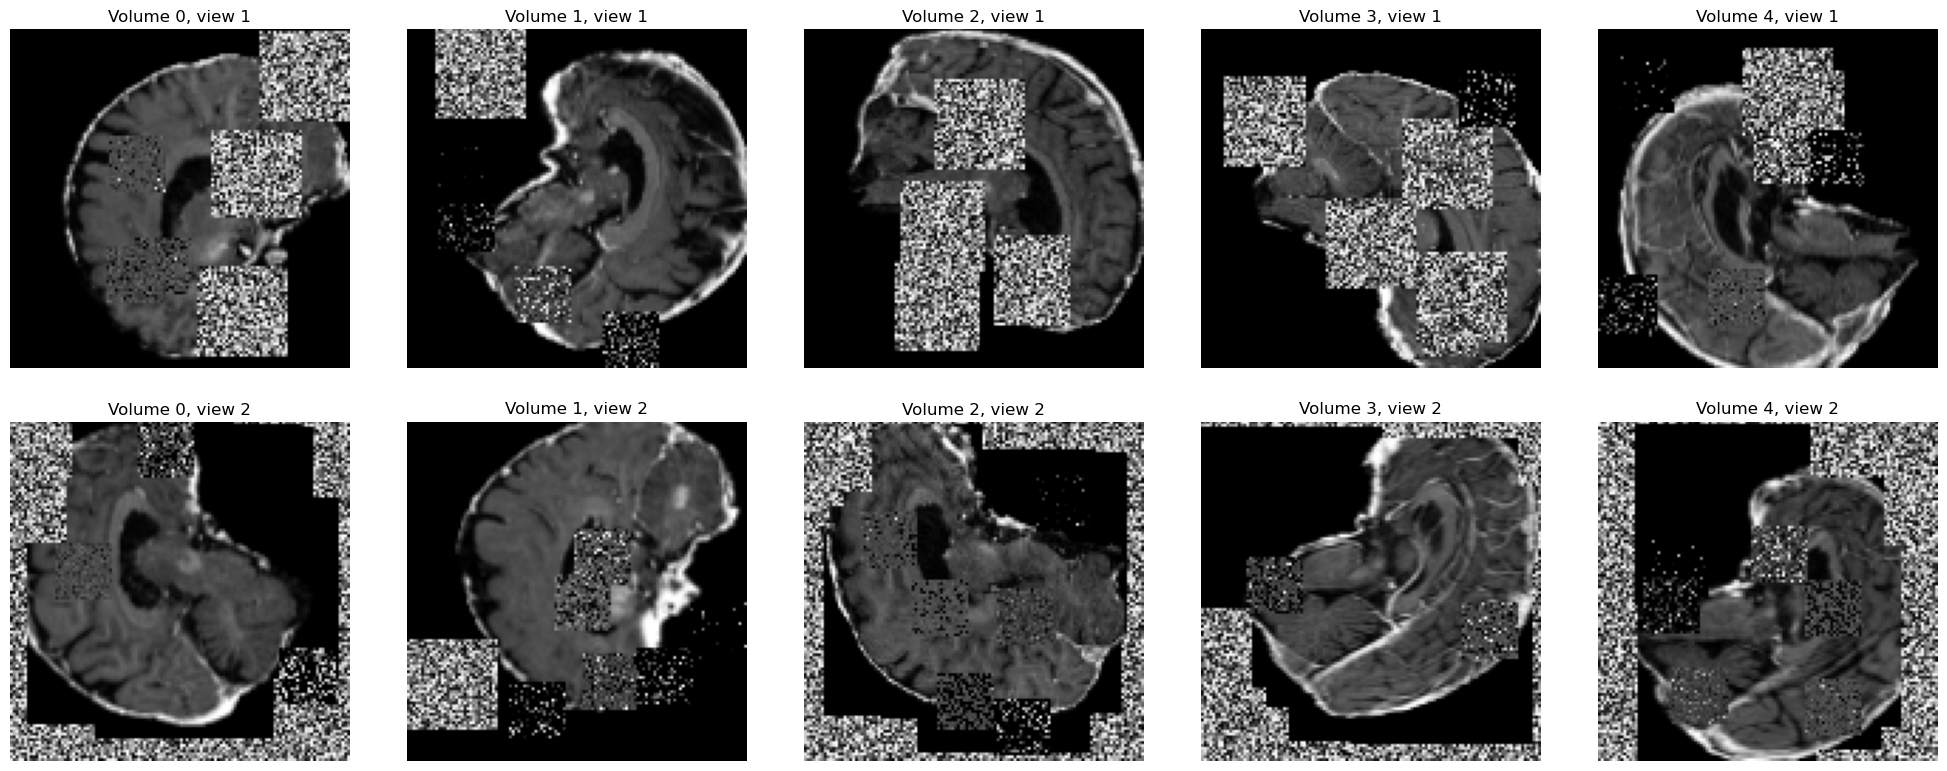

In [52]:
# plot images side by side
slice =60
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
plt.tight_layout()
for i in range(5):
    axs[ 0, i].imshow(x_i[i, 0, :, :, slice], cmap='gray')
    axs[ 0, i].axis('off')
    axs[ 0, i].set_title(f'Volume {i}, view 1')
    axs[ 1, i].imshow(x_j[i, 0, :, :, slice], cmap='gray')
    axs[ 1, i].axis('off')
    axs[ 1, i].set_title(f'Volume {i}, view 2')

In [2]:
device = 'cpu'
# load config file  
chkpt_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/new_p1_hmri_outs/6A_hMRI_MTsat_optim_adam_lr_0.01/version_0/checkpoints/epoch=123-val_auroc=0.7321.ckpt')  
exp_dir = chkpt_path.parent.parent.parent
with open(exp_dir /'config_dump.yml', 'r') as f:
    exp_cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

print(exp_dir.name)
# set random seed for reproducibility

# load model
model = Model.load_from_checkpoint(chkpt_path, **exp_cfg['model'])

model = model.to(device)
model.eval()

# create dataset
exp_cfg['dataset']['val_batch_size'] = 1
exp_cfg['dataset']['train_batch_size'] = 1
exp_cfg['dataset']['shuffle'] = False

root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')

augmentations = tio.Compose([                                        
                            # tio.RandomAffine(scales=(0.15, 0.15, 0.15), 
                            #                 degrees=(15, 0, 15),
                            #                 default_pad_value=0),
                            # tio.RandomGamma(p=0.5)
                            ])
data = HMRIDataModule(md_df=md_df,
                    root_dir=root_dir,
                    augment=augmentations,
                    **exp_cfg['dataset'])
data.prepare_data()
data.setup()

6A_hMRI_MTsat_optim_adam_lr_0.01
Non-pretrained model is created.
Pretrained 3D resnet has a single input channel
Drop subjects ['sub-058', 'sub-016']


In [4]:
# load config file  
device = 'cpu'
chkpt_path = Path("/mrhome/alejandrocu/Documents/parkinson_classification/p4_downstream_outs/5B-2_hMRI_MTsat_optim_adam_lr_0.001/version_0/checkpoints/epoch=74-val_auroc=tensor(0.7602, device='cuda:0').ckpt")  
exp_dir = chkpt_path.parent.parent.parent
with open(exp_dir /'config_dump.yml', 'r') as f:
    exp_cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

print(exp_dir.name)

ssl_chkpt_path = Path(exp_cfg['model']['chkpt_path'])
ssl_exp_dir = ssl_chkpt_path.parent.parent.parent
with open(ssl_exp_dir /'config_dump.yml', 'r') as f:
    ssl_exp_cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

pretrained_model = ContrastiveLearning.load_from_checkpoint(ssl_chkpt_path, hpdict=ssl_exp_cfg)

# for downstream task, use commented ModelDownstream class in pl_model.py

model = ModelDownstream(net=pretrained_model.model, **exp_cfg['model'])

5B-2_hMRI_MTsat_optim_adam_lr_0.001


In [3]:
# model = model.to(device)
# model.eval()

with open('./config/config_downstream.yaml', 'r') as f:
        cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

# create dataset
# exp_cfg['dataset']['val_batch_size'] = 1
# exp_cfg['dataset']['train_batch_size'] = 1
# exp_cfg['dataset']['shuffle'] = False

root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')

augmentations = Compose([])

data = HMRIDataModuleDownstream(root_dir=root_dir,
                        md_df=md_df,
                        augment=augmentations,
                        **cfg['dataset'])
data.prepare_data()
data.setup()

dataloaders = {'val': data.val_dataloader(),
                'train': data.train_dataloader()}

Drop subjects ['sub-058', 'sub-016']


In [4]:
for batch in data.train_dataloader():
    x, y = batch
    print(x.shape)
    print(y)
    break

torch.Size([3, 1, 120, 120, 120])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.]])


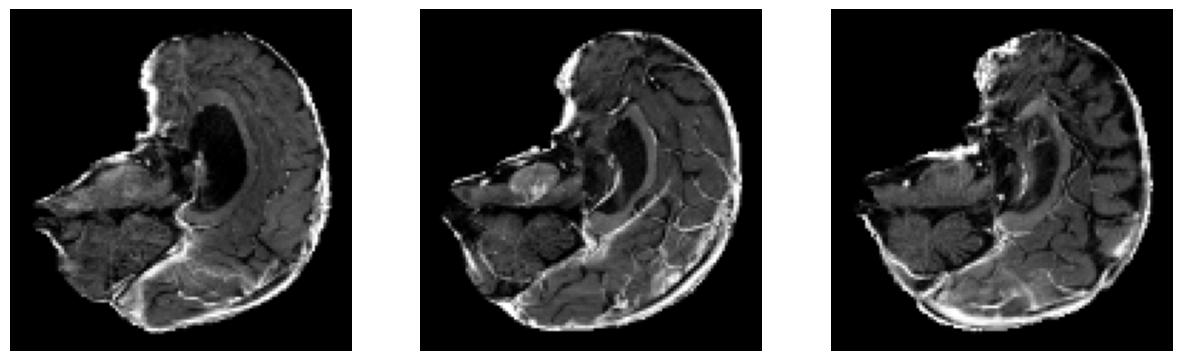

In [6]:
# print inputs
slice_idx = 60
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(x[0, 0, :, :, slice_idx], cmap='gray')
ax[0].axis('off')
ax[1].imshow(x[1, 0, :, :, slice_idx], cmap='gray')
ax[1].axis('off')
ax[2].imshow(x[2, 0, :, :, slice_idx], cmap='gray')
ax[2].axis('off')
plt.show()

In [8]:
inf_pd_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/new_p1_hmri_outs/classification_results/CV4A_val_inference_results.csv')
exps_results_pd_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/new_p1_hmri_outs/classification_results/CV4A_val_exps_results.csv')
exp3_inf_df = pd.read_csv(inf_pd_path, index_col=None)
exp3_exp_df = pd.read_csv(exps_results_pd_path, index_col=None)
exp3_exp_df

,auroc_sm,auroc_log,acc,f1,exp_name,split,map_type,exp_type
0,0.918367,0.877551,0.714286,0.833333,cv2-4A_hMRI_R2s_WLS1_optim_adam_lr_0.01_cv_0,val,R2s_WLS1,CV0
1,0.596939,0.596939,0.642857,0.761905,cv2-4A_hMRI_R2s_WLS1_optim_adam_lr_0.01_cv_1,val,R2s_WLS1,CV1
2,0.729592,0.724490,0.642857,0.782609,cv2-4A_hMRI_R2s_WLS1_optim_adam_lr_0.01_cv_2,val,R2s_WLS1,CV2
3,0.729592,0.734694,0.642857,0.782609,cv2-4A_hMRI_R2s_WLS1_optim_adam_lr_0.01_cv_3,val,R2s_WLS1,CV3
4,0.698980,0.693878,0.642857,0.782609,cv2-4A_hMRI_R2s_WLS1_optim_adam_lr_0.01_cv_4,val,R2s_WLS1,CV4


In [5]:
exp3_inf_df.loc[(exp3_inf_df.map_type == 'R2s_WLS1') & (exp3_inf_df.exp_type == '4A'), :]

,subj_id,preds,logits,targets,sm_preds,split,exp_name,map_type,exp_type
84,sub-021,[1],[[-0.32804772 -0.30352306]],[[0 1]],[[0.49386913 0.5061309 ]],val,4A_hMRI_R2s_WLS1_optim_adam_lr_0.01,R2s_WLS1,4A
85,sub-064,[1],[[-0.35926446 -0.27384937]],[[1 0]],[[0.4786592 0.5213408]],val,4A_hMRI_R2s_WLS1_optim_adam_lr_0.01,R2s_WLS1,4A
86,sub-042,[1],[[-0.34361687 -0.32449526]],[[0 1]],[[0.49521974 0.50478023]],val,4A_hMRI_R2s_WLS1_optim_adam_lr_0.01,R2s_WLS1,4A
87,sub-066,[0],[[-0.32647586 -0.34306616]],[[0 1]],[[0.50414747 0.49585253]],val,4A_hMRI_R2s_WLS1_optim_adam_lr_0.01,R2s_WLS1,4A
88,sub-041,[1],[[-0.53998584 -0.03580791]],[[0 1]],[[0.37655935 0.6234407 ]],val,4A_hMRI_R2s_WLS1_optim_adam_lr_0.01,R2s_WLS1,4A
89,sub-019,[1],[[-0.38056454 -0.28305084]],[[0 1]],[[0.47564086 0.5243591 ]],val,4A_hMRI_R2s_WLS1_optim_adam_lr_0.01,R2s_WLS1,4A
90,sub-036,[0],[[-0.19035244 -0.5044929 ]],[[1 0]],[[0.5778956 0.42210442]],val,4A_hMRI_R2s_WLS1_optim_adam_lr_0.01,R2s_WLS1,4A
91,sub-039,[1],[[-0.34759277 -0.3148206 ]],[[0 1]],[[0.4918077 0.5081923]],val,4A_hMRI_R2s_WLS1_optim_adam_lr_0.01,R2s_WLS1,4A
92,sub-035,[1],[[-0.47935876 -0.15033805]],[[0 1]],[[0.41847894 0.5815211 ]],val,4A_hMRI_R2s_WLS1_optim_adam_lr_0.01,R2s_WLS1,4A
93,sub-071,[1],[[-0.37187958 -0.25341493]],[[0 1]],[[0.47041842 0.52958155]],val,4A_hMRI_R2s_WLS1_optim_adam_lr_0.01,R2s_WLS1,4A


In [2]:
with open('config/config.yaml', 'r') as f:
    cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
pd_number = len(md_df.loc[md_df.group == 1, :])
hc_number = len(md_df.loc[md_df.group == 0, :])
print(f'------------\n Data - PD: {pd_number}, HC: {hc_number}')

augmentations = tio.Compose([                                        
                            tio.RandomAffine(scales=(0.15, 0.15, 0.15), 
                                            degrees=(15, 0, 15),
                                            # isotropic=True,
                                            # center='image',
                                            default_pad_value=0),
                            # # tio.RandomElasticDeformation(p=0.1, num_control_points=7, max_displacement=10),
                            tio.RandomGamma(p=0.5),
                            # # tio.RandomNoise(p=0.5, mean=0.5, std=0.05), # p=0.5
                            # # tio.RandomMotion(p=0.1), #, degrees=20, translation=20),
                            # # tio.RandomBiasField(p=0.25),
                            ])

data = HMRIDataModule(md_df=md_df,
                        root_dir=root_dir,
                        augment=augmentations,
                        **cfg['dataset'])
data.prepare_data()
data.setup()


------------
 Data - PD: 49, HC: 23
Drop subjects ['sub-058', 'sub-016']


In [88]:
data.md_df_val.group.value_counts()

1    9
0    5
Name: group, dtype: int64

In [18]:
 # create model
pretrained_model = get_pretrained_model(chkpt_path=Path(cfg['model']['chkpt_path']),
                                input_channels=cfg['model']['in_channels'])
model = Model(net=pretrained_model.net, **cfg['model'])

# model.to('cpu')
# model.net


loading pretrained model pretrain/resnet_10_23dataset.pth
Pretrained 3D resnet has a single input channel


In [ ]:
model = Model(net='3dresnet', **cfg['model'])
model.net.conv1.weight

In [3]:
for batch in data.train_dataloader():
    inputs, targets = batch['image'][tio.DATA], batch['label']
    print(inputs.shape)
    break

torch.Size([3, 1, 180, 180, 180])


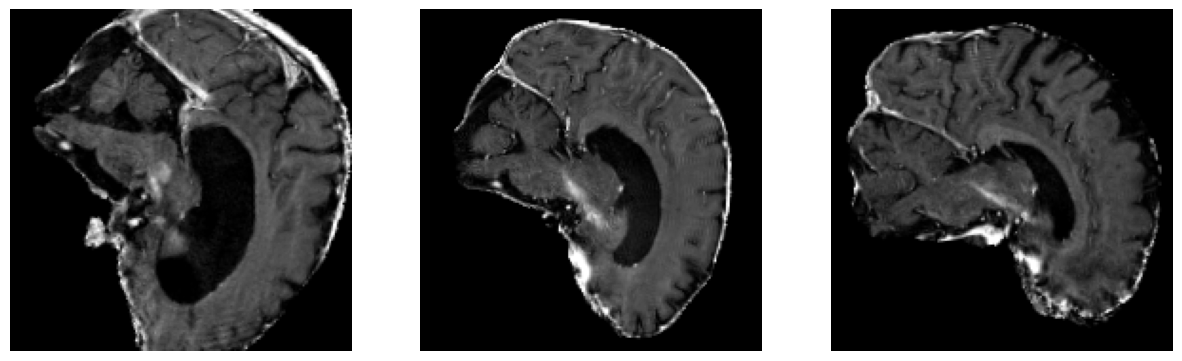

In [4]:
# print inputs
slice_idx = 80
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(inputs[0, 0, slice_idx, :, :], cmap='gray')
ax[0].axis('off')
ax[1].imshow(inputs[1, 0, slice_idx, :, :], cmap='gray')
ax[1].axis('off')
ax[2].imshow(inputs[2, 0, slice_idx, :, :], cmap='gray')
ax[2].axis('off')
plt.show()

In [11]:
# inputs = torch.randn(1, 1, 200, 200, 200)
outputs = model.net(inputs)

In [12]:
outputs.shape

torch.Size([3, 2])

### Creating MD

In [12]:
data_folder = Path('/mnt/projects/7TPD')
bids_folder = data_folder / 'bids'
bids_folder.exists()

True

In [13]:
metadata = []
for n, folder in enumerate(bids_folder.iterdir()):
    if folder.is_dir():
        px_data = {}
        if 'sub-' in folder.name:
            px_data['id'] = folder.name
            px_data['s01-7t'] = False
            px_data['s01-3t'] = False
            px_data['s02-7t'] = False
            px_data['s03-7t'] = False
            for session in folder.iterdir():    

                if '01achieva7t' in session.name:                    
                    px_data['s01-7t'] = True
                    px_data['s01-7t-anat'] = None
                    px_data['s01-7t-fmap'] = None
                    for dtype_folder in session.iterdir():
                        if 'anat' in dtype_folder.name:
                            sequences = [image.name.split('01achieva7t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s01-7t-anat'] = sequences
                        if 'fmap' in dtype_folder.name:
                            sequences = [image.name.split('01achieva7t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s01-7t-fmap'] = sequences

                elif '01prisma3t' in session.name:
                    px_data['s01-3t'] = True
                    px_data['s01-3t-anat'] = None
                    px_data['s01-3t-fmap'] = None
                    px_data['s01-3t-dwi'] = None
                    px_data['s01-3t-func'] = None
                    for dtype_folder in session.iterdir():
                        if 'anat' in dtype_folder.name:
                            sequences = [image.name.split('01prisma3t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s01-3t-anat'] = sequences
                        if 'fmap' in dtype_folder.name:
                            sequences = [image.name.split('01prisma3t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s01-3t-fmap'] = sequences
                        if 'dwi' in dtype_folder.name:
                            sequences = [image.name.split('01prisma3t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s01-3t-dwi'] = sequences
                        if 'func' in dtype_folder.name:
                            sequences = [image.name.split('01prisma3t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s01-3t-func'] = sequences

                elif '02achieva7t' in session.name:
                    px_data['s02-7t'] = True
                    px_data['s02-7t-anat'] = None
                    px_data['s02-7t-fmap'] = None
                    # px_data['s02-7t-dwi'] = None
                    px_data['s02-7t-func'] = None
                    for dtype_folder in session.iterdir():
                        if 'anat' in dtype_folder.name:
                            sequences = [image.name.split('02achieva7t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s02-7t-anat'] = sequences
                        if 'fmap' in dtype_folder.name:
                            sequences = [image.name.split('02achieva7t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s02-7t-fmap'] = sequences
                        # if 'dwi' in dtype_folder.name:
                        #     sequences = [image.name.split('02achieva7t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                        #     px_data['s02-7t-dwi'] = sequences
                        if 'func' in dtype_folder.name:
                            sequences = [image.name.split('02achieva7t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s02-7t-func'] = sequences

                elif '03achieva7t' in session.name:
                    px_data['s03-7t'] = True
                    px_data['s03-7t-anat'] = None
                    px_data['s03-7t-fmap'] = None
                    # px_data['s03-7t-dwi'] = None
                    px_data['s03-7t-func'] = None
                    for dtype_folder in session.iterdir():
                        if 'anat' in dtype_folder.name:
                            sequences = [image.name.split('03achieva7t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s03-7t-anat'] = sequences
                        if 'fmap' in dtype_folder.name:
                            sequences = [image.name.split('03achieva7t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s03-7t-fmap'] = sequences
                        # if 'dwi' in dtype_folder.name:
                        #     sequences = [image.name.split('03achieva7t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            # px_data['s03-7t-dwi'] = sequences
                        if 'func' in dtype_folder.name:
                            sequences = [image.name.split('03achieva7t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s03-7t-func'] = sequences        
            metadata.append(px_data)
            # if n > 3:
            #     break   
# pd.DataFrame(metadata)            

In [14]:
pd.DataFrame(metadata).fillna(0).to_csv(this_path/'metadata2.csv')

### Reading data files

In [32]:
# pd.DataFrame(metadata).fillna(0).to_csv(this_path/'metadata.csv')
# df = pd.DataFrame(metadata).fillna(0)

# reading original metadata
# bids_df = pd.read_csv(this_path/'metadata.csv', index_col=0)

# reading second run metadata
bids_df = pd.read_csv(this_path/'metadata2.csv', index_col=0)
subreg_df = pd.read_excel(this_path/"subject_registry_Birgitte_acu.xls")
subreg_df.drop(['Ini', 'name', 'tel', 'email', 'Audiometry'], axis=1, inplace=True)
log2bids_df = pd.read_excel(this_path/"logno2bids_acu.xls")

In [3]:
log2bids_df.rename(columns={'subject_id':'X-number'}, inplace=True)
log2bids_df = log2bids_df.loc[:, ['X-number', 'participant_id']]
x2bidsmap = {}
for i, data in log2bids_df.iterrows():
    if data['X-number'] in x2bidsmap.keys() and data['participant_id'] != x2bidsmap[data['X-number']]:
        print('duplicate', x2bidsmap[data['X-number']])
        print(data)
        # print(data)
    else:
        x2bidsmap[data['X-number']] = data['participant_id']


# res = log2bids_df[log2bids_df.duplicated(subset=['X-number', 'participant_id'], keep=False)]
# res.sort_values('X-number')

duplicate sub-098
X-number           X37397
participant_id    sub-123
Name: 294, dtype: object
duplicate sub-082
X-number           X11901
participant_id    sub-124
Name: 295, dtype: object


In [4]:
bids2xmap = {}
for i, data in log2bids_df.iterrows():
    if data['participant_id'] in bids2xmap.keys() and data['X-number'] != bids2xmap[data['participant_id']]:
        print('Duplicated bids', bids2xmap['participant_id'])
        print(data)
    else:
        bids2xmap[data['participant_id']] = data['X-number']

In [5]:
log2bids_df

,X-number,participant_id
0,X40270,sub-001
1,X94582,sub-002
2,X46603,sub-003
3,X83822,sub-004
4,X52338,sub-005
...,...,...
304,X27474,sub-125
305,X84202,sub-126
306,X15094,sub-127
307,X36063,sub-128


In [6]:
subreg_df

,SubID,group,sex (f=1),age,X-number,Date Day1,Notes Day1,RedCap completed,Date Day2,K-no D2,L-no D2,XNAT,Projects,Day 3 + 4,LC vis (l/r),Notes Day2,D2status
0,PD01,1,0.0,78.0,X40270,19.09.2018,OK,Y,29.09.2018,K0556,NaN,NaN,y,"Y, but structural low qual",U/N,First MT-weighted image with folding-in of ear...,OK
1,HC01,0,1.0,76.0,X94582,19.09.2018,OK,Y,29.09.2018,K0557,NaN,NaN,y,"Y, but structural low qual. Maybe call",Y/Y,First MT-weighted image with folding-in of ear...,OK
2,PD02,1,0.0,72.0,X46603,24.09.2018,"BP, BIS-11, QUIP 18/11-18",Y,18.11.2018,K0621,L565,Y,y,N,Y/Y,C46603 on Achieva. Hypointensity in left cauda...,OK
3,PD03,1,0.0,60.0,X83822,12.10.2018,OK,Y,28.10.2018,K0589,L634,Y,y,"K0899,",Y/N,3T Prisma out of order. Participant agrees to ...,NO
4,PD04,1,0.0,38.0,X52338,12.10.2018,OK,Y,28.10.2018,K0590,K564,Y,y,"Audiometry: OK, apart from 6K right",Y/Y,3T Prisma out of order 28/10. Participant agre...,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,PD77,1,1.0,49.0,X90517,14.06.2022,OK,Y,01.07.2022,K1706,NaN,y,y,NaN,NaN,NaN,OK
123,PD78,1,0.0,57.0,X80973,27.05.2022,OK,N,NaN,NaN,NaN,NaN,NaN,Under udredning for atypisk PD,NaN,NaN,EXC
124,PD79,1,0.0,59.0,X85428,14.06.2022,OK,Y,07.07.2022,K1714,NaN,y,y,NaN,NaN,NaN,OK
125,PD80,1,0.0,81.0,X57407,15.08.2022,OK,Y,18.08.2022,K1743,NaN,y,n,Bad hearing,NaN,Shoulder pain during scan. Had to restart. Use...,OK


In [33]:
subreg_df['subject'] = [x2bidsmap[x] if x in x2bidsmap.keys() else 'None' for x in subreg_df['X-number'].values]

In [34]:
# patients with no BIDS number (ID) and D2Status as EXC (excluded) = 13
subreg_df.loc[subreg_df.subject == 'None', :]

,SubID,group,sex (f=1),age,X-number,Date Day1,Notes Day1,RedCap completed,Date Day2,K-no D2,L-no D2,XNAT,Projects,Day 3 + 4,LC vis (l/r),Notes Day2,D2status,subject
8,PD08,1,1.0,70.0,X27455,02.11.2018,OK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Knækket metalbor I tand. Ikke sikkert skannerk...,EXC,None
11,PD11,1,NaN,NaN,X05588,20.11.2018,OK,NaN,16.12.2018,NaN,NaN,NaN,NaN,NaN,NaN,Not scanned on 16.12.2018 due to unreported ta...,EXC,None
27,HC05,0,NaN,NaN,X70177,15.05.2019,Subject excluded due to migraine.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
59,PD41,1,1.0,71.0,X13338,29.06.2020,Excluded due to history w SAH,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
61,HC21,0,1.0,40.0,X62925,04.08.2020,OK,Y,12.10.2020,NaN,NaN,NaN,NaN,NaN,NaN,Dropped out before D2,EXC,None
64,PD44,1,1.0,53.0,X40631,26.08.2020,Excluded due to tattoo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
72,HC24,0,0.0,61.0,X14750,21.09.2020,Excluded due to migraine,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
76,PSP1,2,0.0,70.0,X62548,01.09.2021,Excluded – Can’t lie flat,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
84,PSP3,2,0.0,79.0,X28945,07.10.2021,Excluded – skruer I venstre skulder,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
89,PD58,1,1.0,65.0,X16286,15.11.2021,OK,Y,24.11.2021,K1423,NaN,y,n,NaN,NaN,Many technical problems so the scan took 45 mi...,EXC,None


In [35]:
# PSP patients
subreg_df.loc[subreg_df.group == 2, ['group', 'subject','X-number']]

,group,subject,X-number
76,2,None,X62548
82,2,sub-110,X58138
84,2,None,X28945
91,2,sub-111,X69801
97,2,sub-112,X49006
99,2,sub-113,X60759
101,2,None,X89998
103,2,sub-114,X11763
107,2,sub-115,X73740
110,2,sub-116,X59156


In [21]:

# # md_df = subreg_df.join(log2bids_df.loc[:, ['X-number', 'participant_id']], lsuffix='_o', rsuffix='_n')
# # md_df = pd.merge(subreg_df, log2bids_df, on='X-number') # right_on=['X-number', 'participant_id']
# md_df = pd.merge(subreg_df, log2bids_df, on='X-number')

# # md_df.drop(['X-number_n'], axis=1, inplace=Trdue)
# md_df.rename(columns={'participant_id':'subject'}, inplace=True)

# # Filter with OK status for Day 2
# # md_df = md_df.loc[md_df.D2status == 'OK', :] 
# md_df

In [35]:
md_df = subreg_df.loc[subreg_df.subject != 'None', :]
md_df.fillna('None', inplace=True)
md_df_s01 = md_df.loc[(md_df['K-no D2'] != 'None') & (md_df['L-no D2'] != 'None'), :]
md_df_s01 = md_df_s01.loc[md_df.group != 2, :]
names_md_df_s01 = md_df_s01.loc[:, 'subject'].values
print(f'DF shape: {md_df_s01.shape}')
print(f'PD: {(md_df_s01.group == 1).sum()}')
print(f'HC: {(md_df_s01.group == 0).sum()}')

DF shape: (72, 18)
PD: 49
HC: 23


/tmp/ipykernel_2224812/1907910632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  md_df.fillna('None', inplace=True)


In [10]:
print(names_md_df_s01)
print(len(names_md_df_s01))
print(len(np.unique(names_md_df_s01)))

['sub-003' 'sub-004' 'sub-005' 'sub-006' 'sub-007' 'sub-008' 'sub-009'
 'sub-010' 'sub-011' 'sub-012' 'sub-013' 'sub-014' 'sub-015' 'sub-016'
 'sub-017' 'sub-018' 'sub-019' 'sub-020' 'sub-021' 'sub-022' 'sub-023'
 'sub-024' 'sub-025' 'sub-026' 'sub-027' 'sub-028' 'sub-029' 'sub-030'
 'sub-031' 'sub-032' 'sub-033' 'sub-034' 'sub-035' 'sub-036' 'sub-037'
 'sub-038' 'sub-039' 'sub-040' 'sub-041' 'sub-042' 'sub-043' 'sub-044'
 'sub-045' 'sub-046' 'sub-047' 'sub-048' 'sub-049' 'sub-050' 'sub-051'
 'sub-052' 'sub-053' 'sub-054' 'sub-055' 'sub-056' 'sub-057' 'sub-058'
 'sub-059' 'sub-060' 'sub-061' 'sub-062' 'sub-063' 'sub-064' 'sub-065'
 'sub-066' 'sub-067' 'sub-068' 'sub-069' 'sub-070' 'sub-071' 'sub-072'
 'sub-073' 'sub-074']
72
72


In [14]:
names_md_df_s01_no = [int(subject.split('-')[-1]) for subject in names_md_df_s01]
print(names_md_df_s01_no)

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]


In [21]:
# patients that have both 7t and 3t (ses-01)
names_bids = bids_df.loc[(bids_df['s01-7t'] == True) & (bids_df['s01-3t'] == True), 'id'].values
print(names_bids)
print(len(names_bids))
print(len(np.unique(names_bids)))
names_bids_no = sorted([int(subject.split('-')[-1]) for subject in names_bids])

['sub-054' 'sub-044' 'sub-014' 'sub-024' 'sub-003' 'sub-064' 'sub-004'
 'sub-034' 'sub-005' 'sub-061' 'sub-072' 'sub-025' 'sub-021' 'sub-015'
 'sub-032' 'sub-035' 'sub-058' 'sub-065' 'sub-042' 'sub-026' 'sub-013'
 'sub-073' 'sub-006' 'sub-048' 'sub-055' 'sub-033' 'sub-036' 'sub-022'
 'sub-045' 'sub-016' 'sub-020' 'sub-041' 'sub-012' 'sub-027' 'sub-043'
 'sub-007' 'sub-066' 'sub-052' 'sub-037' 'sub-062' 'sub-017' 'sub-063'
 'sub-008' 'sub-053' 'sub-028' 'sub-056' 'sub-038' 'sub-067' 'sub-046'
 'sub-018' 'sub-009' 'sub-029' 'sub-039' 'sub-019' 'sub-010' 'sub-068'
 'sub-071' 'sub-030' 'sub-057' 'sub-040' 'sub-047' 'sub-011' 'sub-031'
 'sub-074' 'sub-069' 'sub-059' 'sub-070' 'sub-023' 'sub-049' 'sub-060'
 'sub-050' 'sub-051']
72
72


In [ ]:
051 052 053 054 055 056 057 058 059 060 061 062 063 064 065 066 067 068 069 070 071 072 073 074

In [22]:
print(names_bids_no)

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]


In [23]:
for sub in range(len(names_bids_no)):
    if names_bids_no[sub] != names_md_df_s01_no[sub]:
        print('Different')
# both list are the same

In [25]:
bids_df.loc[(bids_df['s01-7t'] == True) & (bids_df['s01-3t'] == True), :]

,id,s01-7t,s01-3t,s02-7t,s03-7t,s01-3t-anat,s01-3t-fmap,s01-3t-dwi,s01-3t-func,s01-7t-anat,s01-7t-fmap,s03-7t-anat,s03-7t-fmap,s03-7t-func,s02-7t-anat,s02-7t-fmap,s02-7t-func,group
0,sub-054,True,True,True,True,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskDA_dir-PA_epi.nii.gz', '_acq-w...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-slabTaskDA_dir-PA_run-1_epi.nii.gz', '_...","['_task-NA_acq-whole_dir-AP_bold.nii.gz', '_ta...","56 0 Name: group, dtype: int64"
1,sub-044,True,True,True,True,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskDA_dir-PA_epi.nii.gz', '_acq-w...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskDA_dir-PA_epi.nii.gz', '_acq-w...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '...","46 0 Name: group, dtype: int64"
4,sub-014,True,True,False,False,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",0,0,0,0,0,0,"15 1 Name: group, dtype: int64"
5,sub-024,True,True,False,False,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",0,0,0,0,0,0,"25 1 Name: group, dtype: int64"
6,sub-003,True,True,False,False,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",0,0,0,0,0,0,"2 1 Name: group, dtype: int64"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,sub-023,True,True,False,False,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",0,0,0,0,0,0,"24 1 Name: group, dtype: int64"
117,sub-049,True,True,True,True,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskNA_dir-PA_epi.nii.gz', '_acq-s...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskNA_dir-PA_epi.nii.gz', '_acq-s...","['_task-NAnoise_acq-slab_dir-AP_bold.nii.gz', ...","51 1 Name: group, dtype: int64"
120,sub-060,True,True,True,True,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskDA_dir-PA_epi.nii.gz', '_acq-w...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskDA_dir-PA_epi.nii.gz', '_acq-w...","['_task-NAiaps_acq-slab_dir-AP

In [40]:
bids_df_3t = bids_df.loc[(bids_df['s01-7t'] == True) & (bids_df['s01-3t'] == True), :]

In [37]:
type(subreg_df.loc[subreg_df.subject == 'sub-054', 'group'].item())

int

In [41]:
bids_df_3t['group'] = [subreg_df.loc[subreg_df.subject == x, 'group'].item() for x in bids_df_3t['id'].values]

/tmp/ipykernel_2224812/3095316622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bids_df_3t['group'] = [subreg_df.loc[subreg_df.subject == x, 'group'].item() for x in bids_df_3t['id'].values]


In [48]:
bids_df_3t = bids_df_3t.loc[:, ['id', 's01-7t', 's01-3t', 's02-7t', 's03-7t', 'group']]
bids_df_3t.sort_values('id', inplace=True)
bids_df_3t
# bids_df_3t.to_csv(this_path/'bids_3t.csv', index=False)

,id,s01-7t,s01-3t,s02-7t,s03-7t,group
6,sub-003,True,True,False,False,1
8,sub-004,True,True,True,True,1
10,sub-005,True,True,True,True,1
28,sub-006,True,True,False,False,1
47,sub-007,True,True,False,False,1
...,...,...,...,...,...,...
113,sub-070,True,True,True,True,1
92,sub-071,True,True,True,True,1
12,sub-072,True,True,False,False,1
27,sub-073,True,True,False,False,1


In [31]:
len(bids_df)

129

In [30]:
bids_df.loc[bids_df['s01-7t'] == True, :]

,id,s01-7t,s01-3t,s02-7t,s03-7t,s01-3t-anat,s01-3t-fmap,s01-3t-dwi,s01-3t-func,s01-7t-anat,s01-7t-fmap,s03-7t-anat,s03-7t-fmap,s03-7t-func,s02-7t-anat,s02-7t-fmap,s02-7t-func
0,sub-054,True,True,True,True,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskDA_dir-PA_epi.nii.gz', '_acq-w...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-slabTaskDA_dir-PA_run-1_epi.nii.gz', '_...","['_task-NA_acq-whole_dir-AP_bold.nii.gz', '_ta..."
1,sub-044,True,True,True,True,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskDA_dir-PA_epi.nii.gz', '_acq-w...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskDA_dir-PA_epi.nii.gz', '_acq-w...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '..."
2,sub-075,True,False,True,True,0,0,0,0,"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskDA_dir-PA_epi.nii.gz', '_acq-w...","['_task-NA_acq-whole_dir-AP_bold.nii.gz', '_ta...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskDA_dir-PA_epi.nii.gz', '_acq-w...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '..."
3,sub-095,True,False,True,False,0,0,0,0,"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",0,0,0,['_acq-MPRAGE_T1w.nii.gz'],0,0
4,sub-014,True,True,False,False,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,sub-125,True,False,False,False,0,0,0,0,"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",0,0,0,0,0,0
125,sub-051,True,True,True,True,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskNA_dir-PA_epi.nii.gz', '_acq-s...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskNA_dir-PA_epi.nii.gz', '_acq-s...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '..."
126,sub-094,True,False,False,False,0,0,0,0,"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",0,0,0,0,0,0
127,sub-126,True,False,False,False,0,0,0,0,"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",0,0,0,0,0,0


In [32]:
# DIFFERENCE BETWEEN TWO SETS
list(set(list(names_md_df_s01)) - set(list(names_bids)))

['sub-074', 'sub-071', 'sub-072', 'sub-070', 'sub-073']

In [29]:
md_df_s01.loc[md_df_s01.subject == 'sub-074', :]

,SubID,group,sex (f=1),age,X-number,Date Day1,Notes Day1,RedCap completed,Date Day2,K-no D2,L-no D2,XNAT,Projects,Day 3 + 4,LC vis (l/r),Notes Day2,D2status,subject
83,PD55,1,0.0,59.0,X32170,05.10.2021,OK,Y,26.10.2021,K1388,L1383,y,y,None,None,OK,OK,sub-074


In [30]:
md_df_s01.loc[md_df_s01['X-number'] == 'X52338', :]

,SubID,group,sex (f=1),age,X-number,Date Day1,Notes Day1,RedCap completed,Date Day2,K-no D2,L-no D2,XNAT,Projects,Day 3 + 4,LC vis (l/r),Notes Day2,D2status,subject
4,PD04,1,0.0,38.0,X52338,12.10.2018,OK,Y,28.10.2018,K0590,K564,Y,y,"Audiometry: OK, apart from 6K right",Y/Y,3T Prisma out of order 28/10. Participant agre...,NO,sub-005


In [24]:
list(set(list(names_bids)) - set(list(names_md_df_s01)))

[]

In [15]:
subreg_df.loc[subreg_df.D2status == 'EXC', :]

,SubID,group,sex (f=1),age,X-number,Date Day1,Notes Day1,RedCap completed,Date Day2,K-no D2,L-no D2,XNAT,Projects,Day 3 + 4,LC vis (l/r),Notes Day2,D2status,subject
8,PD08,1,1.0,70.0,X27455,02.11.2018,OK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Knækket metalbor I tand. Ikke sikkert skannerk...,EXC,None
11,PD11,1,NaN,NaN,X05588,20.11.2018,OK,NaN,16.12.2018,NaN,NaN,NaN,NaN,NaN,NaN,Not scanned on 16.12.2018 due to unreported ta...,EXC,None
27,HC05,0,NaN,NaN,X70177,15.05.2019,Subject excluded due to migraine.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
59,PD41,1,1.0,71.0,X13338,29.06.2020,Excluded due to history w SAH,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
61,HC21,0,1.0,40.0,X62925,04.08.2020,OK,Y,12.10.2020,NaN,NaN,NaN,NaN,NaN,NaN,Dropped out before D2,EXC,None
64,PD44,1,1.0,53.0,X40631,26.08.2020,Excluded due to tattoo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
72,HC24,0,0.0,61.0,X14750,21.09.2020,Excluded due to migraine,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
76,PSP1,2,0.0,70.0,X62548,01.09.2021,Excluded – Can’t lie flat,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
84,PSP3,2,0.0,79.0,X28945,07.10.2021,Excluded – skruer I venstre skulder,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
89,PD58,1,1.0,65.0,X16286,15.11.2021,OK,Y,24.11.2021,K1423,NaN,y,n,NaN,NaN,Many technical problems so the scan took 45 mi...,EXC,None
